After...

## Outline

The structure of this blogposts is as follows, we start by briefly introducing the challenge and give an idea of how the target variable looks like. Afterwards we discuss what has been already done during our first attempt, what went wrong and what we learned from that. Then the prediction strategy for this attempt is outlined and lastly, the code implementation of that strategy is shown.

It is worth noting that this blog-post focuses more on the forecasting idea and high-level implementation. The code for all the feature engineering steps is not shown in this blogpost, but is elaborated on in a follow-up post.

## Problem Description

The problem we are tackling comes from a Data Science Challenge from DrivenData.org. To be more specific, we are talking about the DengAI forecasting challenge, which can be read up on [here](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/).

In this challenge we are asked to predict the number of dengue fever in the two cities San Juan and Iquitos given time-series data of several feature variables with around ~900 and ~500 observations for each city respectively.

Given that dengue fever is transmitted by mosquitoes, most features are related to environmental factors such as temperature and precipitation. Especially challenging in this competition is, that we are asked to provide forecasts for around ~250 and ~150 observations in the future respectively. The long-term forecast seems especially challenging when considering that we do not have that many observations to train our model. 

This challenge definitely is one of the more popular ones on DrivenData.org, having more than 9000 participating teams as of March 2021.

### Target variable

One of the first steps before deciding on the strategy of the forecasting methodology is to take a thorough look at the target variable. For this challenge it is to note that we actually have panel data. That means we have time-series data for multiple entities, namely for the two cities San Juan and Iquitos.

When facing panel data, the question arises whether we build one model for each entity, or whether we use one model for both entities. This question is normally answered by comparing the data generating model between entities. If the distribution between entities is fundamentally different, then any prediction model will not be able to learn and understand any statistical pattern when receiving both entities.

Using a Kolmogrov Smirnov test, which checks whether two distributions are significantly different to one another, we conclude that it would be the best to train two different models.

In order to get a first idea of the target variable we are facing, we show in the following the target variable for both cities: San Juan (left) and Iquitos (right).

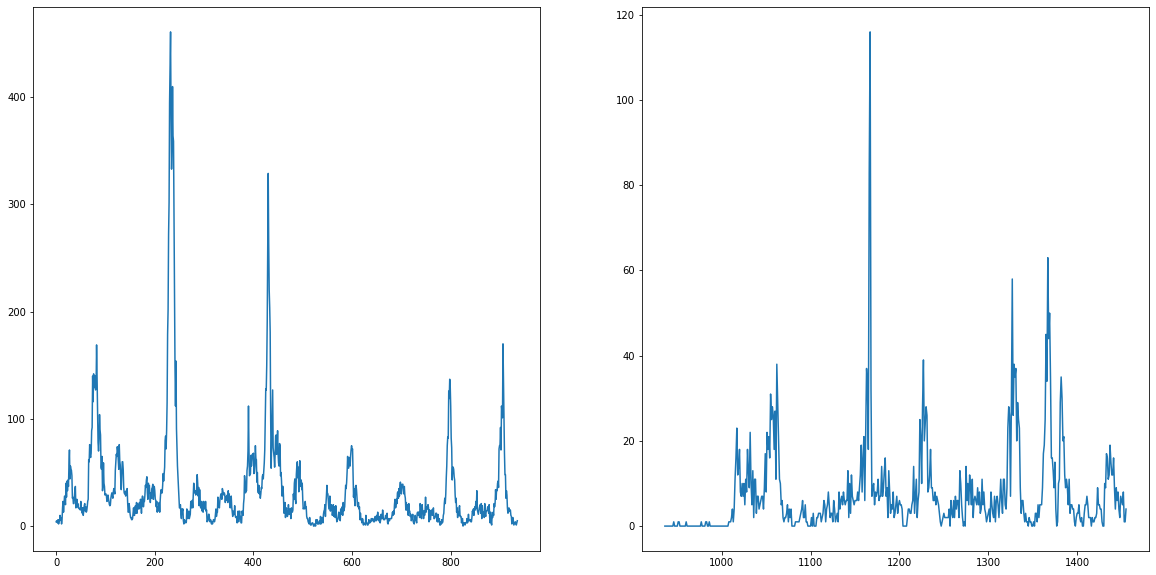

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

os.chdir(r"/Users/paulmora/Documents/projects/dengai_ensemble/")
target_data = pd.read_csv("data/dengue_labels_train.csv")

city_names = set(target_data.loc[:, "city"])
n_cities = len(city_names)
fig, axs = plt.subplots(figsize=(10*n_cities, 10), ncols=n_cities)
axs = axs.ravel()
for i, city in enumerate(city_names):
    city_data = target_data.query("city==@city").loc[:, "total_cases"]
    axs[i].plot(city_data)

## Learnings from previous attempt

Given that we already tried ourselves on the DengAI challenge in the past, it is worthwhile to talk about what has been tried, what went wrong and what could be improved for the next attempt.

During our last attempt we build a [STL Forecasting model](https://www.statsmodels.org/stable/generated/statsmodels.tsa.forecasting.stl.STLForecast.html) with an underlying ARIMA model. The ARIMA was parameterized using the Box-Jenkins methodology, which is the go-to method when doing that.

The flaw of this model, or any ARIMA model, is that those models are not designed for long-term forecasts. That is because all ARIMA models are mean-reverting and therefore useless when it comes to forecasts longer than a few periods. Especially with time-series which are as bumpy as the ones we are trying to predict, this forecasting method was wrongly placed.

One positive aspect of our last attempt was to allow multiple seasonalities through the STL part of the model. STL On the plus site we found that modeling the seasonality through STL went quite well. STL or *seasonal-trend decomposition using LOESS* is normally used to decompose a time series into its three components: seasonality, trend and residual. This is useful and necessary in order to make time-series stationary. The benefit of using the STL forecasting method is that it comes with a forecasting possibility for the seasonality as well.

Our key learnings from last time are therefore to allow for a model which can handle long-term forecasts better and to use a model which is capable of modeling multiple seasonalities.

![Forecasting for out-of-sample San Juan](images/last_attempt_forecast.png)

## Forecasting Methodology

The main problem of predicting the number of dengue fever cases is, as can be seen from the graphs above, that they are dominated by several short but significant outbursts of case numbers, which is very difficult to predict. The inspiration for the potential modeling approach came during one of the brain-storming sessions I had at work. At the time we were working on a prediction model which was supposed to predict damage claims in an insurance context.

As hopefully every reader can related to, most of the time people pay money to their insurance and not the other way around. This already describes the business model of an insurance pretty accurately. Most of the time no accident happens to their clients and the insurance can collect the money in order to be ready to pay out high amounts in case they are needed.

This behavior results in a target variable which is relatively sparse, meaning that most observations are zero. This makes the variable quite difficult to predict. One potential approach to model that behavior is suggested in the paper of Andrea Andrea Dal Pozzolo 2010 [1]. Herein the author splits the forecasting problem into two different parts. Firstly, a classification problems in which we classify whether the claim is having a payout or not. In the second step we apply a regression model to the observations which are non-zero.

The benefit of this approach is that the regression model could focus more on observations which are non-zero and therefore is able to better cope with the spikes within the target.

Initially the approach taken for the insurance claim predictions does not seem completely applicable to our scenario for two main reasons:

1. In contrast to the insurance claims data we do not find many observations within the dengue fever target which are zero
2. In contrast to the outlined paper we face time-series data instead of cross-sectional data

To address those problems the following idea was drafted. Instead of trying to figure out which observations are non-zero, we try in a first instance to figure out which observation belongs to one of the spikes. We do that by separating the target variable into *outliers* and *non-outliers*. For example, we define every observation above the e.g. 90th percentile as outliers and all of the other observations as non-outliers. By doing that we turned the target variable from an integer to a binary, which allows us to apply a classification model. After predicting which observation belongs to the *outliers* class, we apply a regression model on only those observations.

Below we show how exactly that separation would look like, taking the city San Juan and the 90th threshold as an example.

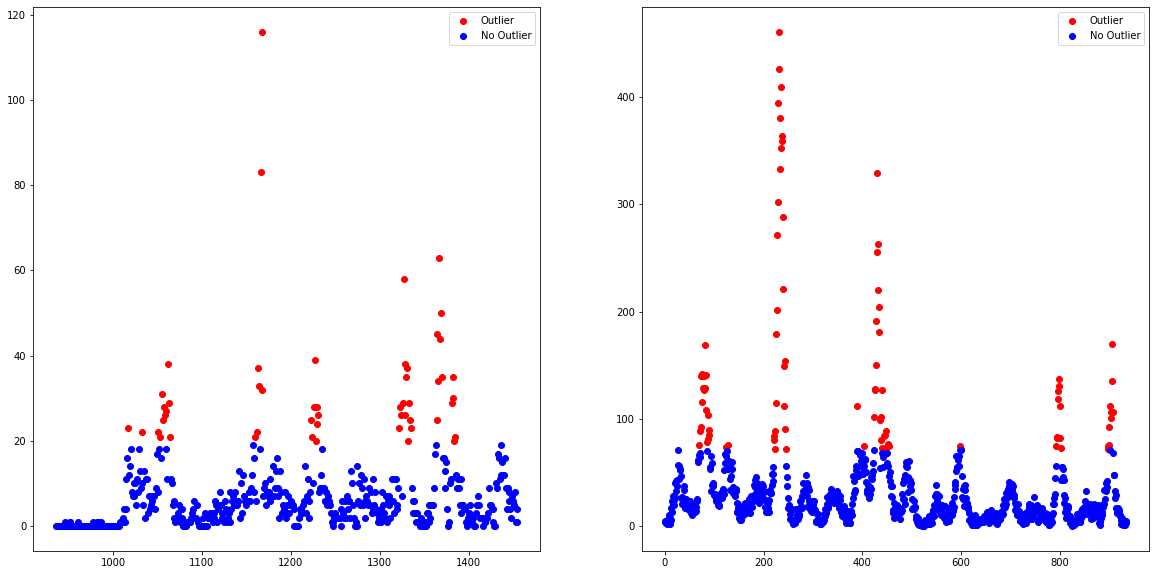

In [4]:
import numpy as np

THRESHOLD = 90
fig, axs = plt.subplots(figsize=(10*n_cities, 10), ncols=n_cities)
axs = axs.ravel()
for i, city in enumerate(city_names):
    city_data = target_data.query("city==@city").loc[:, "total_cases"]
    level_threshold = np.percentile(city_data, THRESHOLD)
    bool_threshold = city_data > level_threshold
    axs[i].plot(city_data[bool_threshold], color="red", label="Outlier", linestyle="None", marker="o")
    axs[i].plot(city_data[~bool_threshold], color="blue", label="No Outlier", linestyle="None", marker="o")
    axs[i].legend()

The other problem we are facing is that we are dealing with a time-series problem in contrast to a cross-sectional problem we were facing within the insurance context. In order to deal with the time-series nature we introduce a third model, namely a smoothing model called TBATS. The exact workings of this model are beyond the scope of this article and will therefore be outlined in a different blogpost. On a high level TBATS takes its roots in exponential smoothing methods. These methods are great to use when facing one or multiple seasonalities. We therefore, apply the TBATS predictions for every observation which is not classified as one of the *outliers* class.

After covering the overall concept, it is now time to see how the high level code implementation looks like.

## Code Implementation

As already mentioned in the beginning of the blogpost, this post does not intend to explain all functions and classes used in the pipelines, but rather discusses the overall modeling approach.

In order to give a better understanding of what is happening under the hood of all the feature engineering classes we wrote a different blogpost which is elaborating on that.

We start by importing all the relevant packages for this project, including packages from other self-written classes and functions.

In [2]:
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as imblearn_make_pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              RandomForestRegressor, GradientBoostingRegressor)
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from src._classes import (Encoding, ColumnCorrection, Transformer, Stationarity, Imputer, FeatureCreation,
                          FeatureSelection, TBATSWrapper, ModelSwitcher)
from src._functions import (city_query, find_top_n_obs, winsorize_data, plot_confusion_matrix,
                            combining_models, plot_prediction_results)
import src._config # Contains matplotlib settings to be applied to all graphs


Potentially worth highlighting is that we are not using the *make_pipeline* function from scikit-learn, but rather the version from the *imblearn* package. The reason for that is that when using any over-/downsampling algorithm from imblearn, the classical scikit-learn pipeline does not work. In order to fix that, the guys from imblearn came up with their own version of pipeline function, which works equally in all respects but allows for over-/downsampling methods.

Next up would be to specify the parameters which feed into the pipeline. Here we will define for example how many cross validations are conducted, what the maximum lag within the feature creation is going to be and so on.

Note that we are choosing *precision* as the classification scoring method since we are more worried about False Positives than False Negatives. This is because of theoretical as well as empirical reasons. When experimenting with different classification models we note that the model labels significantly more observations as *outliers* even though they are not, then the other way around. Given this behavior of being more prone towards to False Positive mistakes it would make sense to fight against that, using the *precision* scoring function. Secondly, labeling an observation as an *outlier* even though it is none would trigger a spike, which is much riskier compared to having a moderate value when it should be a spike 


In [ ]:
# Pipeline settings
cv = 3
N_NEIGHBOURS = 10
DEGREE = 2
MAX_LAG = 4
SIGNIFICANCE_LEVEL = 5 / 100
RS = 42
e_list = [0.01, 0.05, 0.1, 0.25, 0.5]
clf_scoring = "precision"
reg_scoring = "neg_mean_absolute_error"

### Classification Pipeline

The next step is now to set up the first step of the forecasting methodology, which is the pipeline for predicting whether the observation belongs to the *outlier* class. For the **FeatureSelection** class we have to specify that we are dealing with a classification problem compared to a regression problem.

Furthermore, we are specifying an oversampling algorithm SMOTE into the pipeline, given that by the very nature of predicting *outliers* we do not have many observations of the *outliers* class. In order to be a bit more flexible on the amount of oversampling, we allow for the *sampling_strategy* values of 0.5 and 1 within the gridsearch.

Given that we would like to try multiple forecasting models with the pipeline, we apply the trick of creating a **ModelSwitcher** class which can intake different models as hyper-parameters within a gridsearch operation. The range of models we would like to try are stated below as well. Given that the feature-selection class needs a prediction model specified as well, in order to find the optimal value for *e*, a parameter explained in the pipeline blog-post, we have to specify the model twice. Given run-time considerations we only allowed hyper-parameterization for one of the two times the prediction model is called.

In [ ]:

# Classification Pipeline
clf_pipeline = imblearn_make_pipeline(
    Encoding(),
    ColumnCorrection(),
    Stationarity(SIGNIFICANCE_LEVEL=SIGNIFICANCE_LEVEL),
    Transformer(),
    Imputer(n_neighbors=N_NEIGHBOURS),
    FeatureCreation(degree=DEGREE, max_lag=MAX_LAG),
    FeatureSelection(e_list=e_list, scoring=clf_scoring, clf=True),
    SMOTE(random_state=RS),
    ModelSwitcher()
)

clf_parameters = [
    {"modelswitcher__estimator": [svm.SVC(random_state=RS)],
     "modelswitcher__estimator__C": [0.1, 1, 5],
     "featureselection__estimator": [svm.SVC(random_state=RS)],
     "smote__sampling_strategy": [0.5, 1]},

    {"modelswitcher__estimator": [LogisticRegression(random_state=RS)],
     "modelswitcher__estimator__C": [0.1, 1, 2],
     "featureselection__estimator": [LogisticRegression(random_state=RS)],
     "smote__sampling_strategy": [0.5, 1]},

    {"modelswitcher__estimator": [RandomForestClassifier(random_state=RS)],
     "modelswitcher__estimator__min_samples_leaf": [1, 5, 10],
     "featureselection__estimator": [RandomForestClassifier(random_state=RS)],
     "smote__sampling_strategy": [0.5]},

    {"modelswitcher__estimator": [GradientBoostingClassifier(random_state=RS)],
     "modelswitcher__estimator__learning_rate": [0.01, 0.1, 0.2],
     "featureselection__estimator": [GradientBoostingClassifier(random_state=RS)],
     "smote__sampling_strategy": [0.5, 1]},
]

clf_gscv = GridSearchCV(estimator=clf_pipeline, param_grid=clf_parameters, scoring=clf_scoring, cv=cv)


### Regression Pipeline

The pipeline for the regression part of this forecasting is pretty similar to the pipeline used for classification purposes. The main differences being only that we do not have any oversampling class implemented and that we are now gridsearching over regression instead as over classification models.


In [ ]:

# Regression Pipeline
reg_pipeline = imblearn_make_pipeline(
    Encoding(),
    ColumnCorrection(),
    Stationarity(SIGNIFICANCE_LEVEL=SIGNIFICANCE_LEVEL),
    Transformer(),
    Imputer(n_neighbors=N_NEIGHBOURS),
    FeatureCreation(degree=DEGREE, max_lag=MAX_LAG),
    FeatureSelection(e_list=e_list, scoring=reg_scoring, clf=False),
    ModelSwitcher()
)

reg_parameters = [
    {"modelswitcher__estimator": [LinearRegression()],
     "featureselection__estimator": [LinearRegression()]},

    {"modelswitcher__estimator": [RandomForestRegressor(random_state=RS)],
     "modelswitcher__estimator__min_samples_leaf": [1, 5, 10, 20],
     "featureselection__estimator": [RandomForestRegressor(random_state=RS)]},

    {"modelswitcher__estimator": [GradientBoostingRegressor(random_state=RS)],
     "modelswitcher__estimator__min_samples_leaf": [1, 5, 10],
     "modelswitcher__estimator__max_depth": [3, 5, 10],
     "modelswitcher__estimator__learning_rate": [0.01, 0.1, 0.2],
     "featureselection__estimator": [GradientBoostingRegressor(random_state=RS)]}
]

reg_gscv = GridSearchCV(estimator=reg_pipeline, param_grid=reg_parameters, scoring=reg_scoring, cv=cv)


Lastly, we implement the entire forecasting methodology in one function. The functions starts by querying the data for the respective city and divides it into the trainings-features, test-features and trainings-target. Afterwards we turn the target variable into a binary variable by separating the observations into *outliers* and *non-outliers*. Directly afterwards we can apply the pre-defined classification gridsearch algorithm before using the best estimator to predict in-sample as well as out-of-sample target values.

In [ ]:

def make_predictions(city, threshold):

    # Extract the data
    X_train, X_test, y_train = city_query(city)

    # Classification
    binary_target = find_top_n_obs(target=y_train, threshold=threshold, city=city)
    clf_gscv.fit(X_train, binary_target)
    clf_pred_train = clf_gscv.best_estimator_.predict(X_train)
    clf_pred_test = clf_gscv.best_estimator_.predict(X_test)
    plot_confusion_matrix(y_true=binary_target, y_pred=clf_pred_train, city=city, threshold=threshold)

    # Regression
    subset_x_train, subset_y_train = X_train.loc[binary_target.values, :], y_train[binary_target.values]
    subset_x_test = X_test.loc[clf_pred_test, :]
    reg_gscv.fit(subset_x_train, subset_y_train)
    reg_y_pred_train = reg_gscv.best_estimator_.predict(subset_x_train).round().astype(int)
    reg_y_pred_test = reg_gscv.best_estimator_.predict(subset_x_test).round().astype(int)

    # Smoother
    winsorized_y_train = winsorize_data(data=y_train, upper_threshold=threshold)
    smt = TBATSWrapper().fit(X=X_train, y=winsorized_y_train)
    smt_pred_train = smt.in_sample_predict()
    smt_pred_test = smt.predict(X=X_test)

    # Combination models
    total_pred_train = combining_models(clf=binary_target.values, reg=reg_y_pred_train,
                                        smt=smt_pred_train, index_df=X_train)
    total_pred_test = combining_models(clf=clf_pred_test, reg=reg_y_pred_test, smt=smt_pred_test, index_df=X_test)
    mae = mean_absolute_error(y_true=y_train, y_pred=total_pred_train)

    return total_pred_train, total_pred_test, mae, clf_gscv.best_params_, reg_gscv.best_params_


In order to have an idea of how good a classification model performs, we plot a confusion matrix of the best performing hyper-parameter version. Below we give an example of the best model for the classification of *outliers* for the city of San Juan when classifying the 95th percentile as the threshold between the *outliers* and *non-outliers* class.

As already mentioned earlier, within this task the classification models tend to have more False Positives than False Negatives, which is nicely visible through the shown image.

![Forecasting for out-of-sample San Juan](images/sj_95.png)

In the end we build the control center from where 

In [ ]:
test_pred_results = {}
threshold_list = [90, 95, 99]
for city in tqdm(["sj", "iq"]):
    train_data, test_data, mae_list, clf_list, reg_list = [], [], [], [], []
    for threshold in tqdm(threshold_list):
        y_pred_train, y_pred_test, mae, clf_dict, reg_dict = make_predictions(city, threshold)
        train_data.append(y_pred_train)
        test_data.append(y_pred_test)
        mae_list.append(mae)
        clf_list.append(clf_dict)
        reg_list.append(reg_dict)

    best_mae_argmin = plot_prediction_results(train_data=train_data, threshold_list=threshold_list,
                                              mae_list=mae_list, city=city)
    test_pred_results[city] = test_data[best_mae_argmin]
    print(clf_list[best_mae_argmin])
    print(reg_list[best_mae_argmin])


## Results

After submitting our predictions...

## Appendix

[1] Andrea Dal Pozzolo. (2010). Comparison of Data Mining Techniques for Insurance Claim Prediction. https://dalpozz.github.io/static/pdf/Claim_prediction.pdf